## Project 1
# Face Recognition
## 1 - 16 Juli 2023
## Teguh Prasetyo
Berikut ini adalah Project ke-1 dari Workshop Computer Vision Specialist.

## Objectives
Tim Engineering diminta untuk melakukan eksperimen dengan 3 algoritma Deep Learning populer yaitu **VGG**, **GoogleNet** dan **ResNet** dan optimalkan penggunaannya (hyperparameter tuning) untuk memprediksi wajah Laki-laki dan wajah Perempuan.

Dari hasil eksperimen, lakukan evaluasi dan penarikan kesimpulan mana algoritma terbaik.

## Experiment 1, Transfer Learning dengan Algoritma VGG-19

* Transfer Learning : VGG-19
* Layer VGG : Freeze all layer
* Fully Connected Layer :
    * Flatten-Dense(256)-Dropout(0.2)-Dense(256)-Dropout(0.2)-Dense(64)-Dropout(0.2)-Dense(32)-Dropout(0.2)-Dense(2)
    * Activation relu & sigmoid
* Learning Rate : 0.00001
* Batch Size : 32
* Epoch : 10
* Optimizer : Adam
* Loss : Sparse Categorical Crossentropy

## Tahapan Analysis untuk Model Terbaik
Berikut adalah tahapan analysis yang digunakan :
1. Data Preparation
    * 1.1. Load Library
    * 1.2. Load Dataset Images dan List of Attribute
    * 1.3. Menampilkan Contoh-contoh Images yang Digunakan
    * 1.4. Menyiapkan List of Attribute yang Sesuai dengan Attribute pada Images
    * 1.5. Menampilkan Images dengan Nama Gender
    * 1.6. Menghitung Jumlah Images Man vs Female
    * 1.7. Balancing Jumlah Images Man vs Female
2. Data Splitting
    * 2.1. Split Data Menjadi Data Train, Test dan Validation
    * 2.2. Data Augmentation untuk Data Train dan Validation
3. Data Modelling (Transfer Learning)
    * 3.1. Data Modelling and Training
        * 3.1.1. Transfer Learning
        * 3.1.2. Membuat Arsitektur Fully Connected Layer
        * 3.1.3. Kompile Model dan Hyperparameter Tuning
        * 3.1.4. Data Training
    * 3.2. Validation Curves
4. Prediction and Testing The Model
    * 4.1. Melakukan Prediksi pada Data Testing
        * 4.1.1. Membandingkan Label Aktual vs Prediksi pada Data Frame
        * 4.1.2. Menampilkan Foto Beserta Label Gender dan Hasil Prediksi
    * 4.2. Confusion Matrix
    * 4.3. Matriks Evaluasi
    * 4.4. Menampilkan Foto Man yang Salah Prediksi
    * 4.5. Menampilkan Foto Female yang Salah Prediksi
5. Save Model
6. Reference

# 1. Data Preparation
## 1.1. Load Library
Meload beberapa library yang akan digunakan

In [1]:
# Load Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import os
import glob
import hashlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.metrics import categorical_crossentropy
from keras.optimizers import Adam

# Code Modif dari Kaggle

## 1.2. Load Dataset
Meload dataset images (foto) dan list of attribute

In [2]:
# Direktori Dataset
BASIC_PATH = './Dataset'
IMG_PATH = os.path.join(BASIC_PATH,'Images')
FEATURE_PATH = os.path.join(BASIC_PATH, 'list_attribute.csv')

# Code Modif dari Kaggle

In [3]:
# Menghitung Jumlah Images
n_images = len(os.listdir(IMG_PATH))
print('Total Foto dalam Dataset :', n_images, "Foto")

# Code Modif dari Kaggle

Total Foto dalam Dataset : 5017 Foto


## 1.3. Contoh Foto yang Digunakan
Menampilkan 10 contoh Foto pada Dataset Images

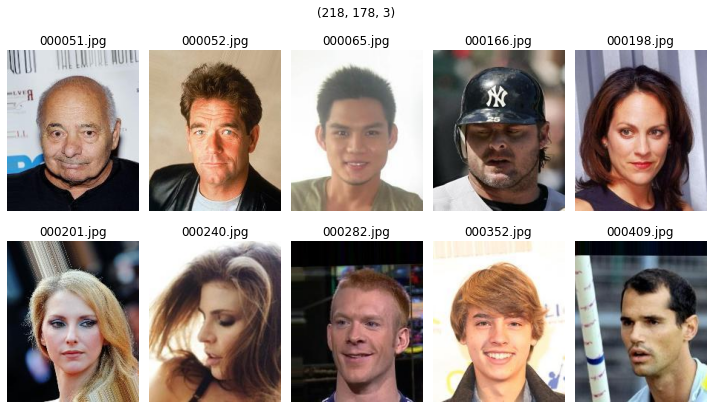

In [4]:
# Menampilkan 10 Foto

# Memperoleh List of Image dari Direktori
image_list = os.listdir(IMG_PATH)

# Membuat suatu subplot dengan 2 baris dan 5 kolom
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (10, 6))

# Menginterasi 10 file pertama dan membuat axis subplot
for i, (image_file, ax) in enumerate(zip(image_list[:10], axes.flatten())):
    
    # Membaca Image dan Memplot Image
    image_path = os.path.join(IMG_PATH, image_file)
    image = plt.imread(image_path)
    ax.imshow(image)
    
    # Setting Judul Plot dari Nama File
    title = image_file
    ax.set_title(title)
    
    # Menampilkan Dimensi Foto sebagai Suptitle
    plt.suptitle(image.shape)

    # Menonaktifkan axis ticks dan labels
    ax.axis('off')

# Mengatur spasi antar subplots
plt.tight_layout()

# Menampilkan Figure
plt.show()

# Code Modif dari Chat GPT

**Note :**
Foto berdimensi 218 x 178 pixel x 3 channel, nama file berisi Id Foto

## 1.4. Menyiapkan Dataset Foto dan List Atribut Foto
### 1.4.1. Melihat Apakah Foto ada yang Double (Duplikat)

Contoh file duplikat:
182793(1).jpg
182793.jpg
182809(1).jpg
182809.jpg
182912(1).jpg
182912.jpg
182943(1).jpg
182943.jpg
Total file duplikat: 17


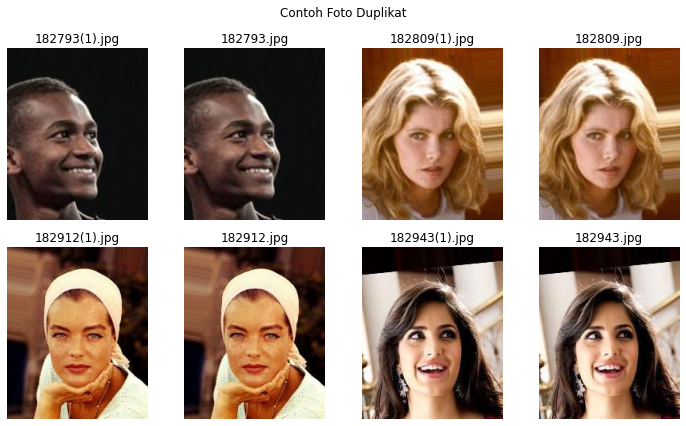

In [5]:
# Mengecek File Duplikat, Menghitung Jumlahnya dan Menampilkan 5 File Contoh

# Library yang digunakan : os dan hashlib

# Mencari semua file dengan ekstensi gambar dalam folder
image_files = [file for file in os.listdir(IMG_PATH) if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Menggunakan dictionary untuk menyimpan hash nilai dan daftar file dengan hash yang sama
duplicate_files = {}

# Memeriksa setiap file gambar
for file_name in image_files:
    file_path = os.path.join(IMG_PATH, file_name)
    with open(file_path, 'rb') as f:
        file_hash = hashlib.md5(f.read()).hexdigest()

    if file_hash not in duplicate_files:
        duplicate_files[file_hash] = [file_name]
    else:
        duplicate_files[file_hash].append(file_name)

# Menghitung total file yang duplikat
total_duplicate_files = sum(len(files) - 1 for files in duplicate_files.values())

# Menampilkan 8 contoh nama file yang duplikat
print("Contoh file duplikat:")
count = 0
for file_list in duplicate_files.values():
    if len(file_list) > 1:
        for file_name in file_list[:8]:
            count += 1
            print(file_name)
            if count == 8:
                break
    if count == 8:
        break

# Menampilkan total file yang duplikat
print(f"Total file duplikat: {total_duplicate_files}")

# Mengumpulkan 8 contoh file duplikat
duplicate_examples = []
for file_list in duplicate_files.values():
    if len(file_list) > 1:
        duplicate_examples.extend(file_list[:8])
    if len(duplicate_examples) >= 10:
        break

# Menampilkan 8 foto duplikat dengan judul sebagai nama file
fig, axes = plt.subplots(2, 4, figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    if i < len(duplicate_examples):
        file_name = duplicate_examples[i]
        file_path = os.path.join(IMG_PATH, file_name)
        image = plt.imread(file_path)
        ax.imshow(image)
        ax.set_title(file_name)
        plt.suptitle('Contoh Foto Duplikat')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Code Modif dari Chat GPT

Note : Jika nama file yang duplikat tersebut (berakhiran '(1)') tidak terdapat dalam list_attribute.csv, maka dapat di abaikan karena ketika di join.inner, maka file duplikat tersebut tidak akan masuk ke dalam list foto (images) yang akan di digunakan untuk training model.

### 1.4.2. Menampilkan List Nama File Foto

In [6]:
# Membuat List Nama File Foto untuk Join dengan Nama File pada File list_attribute.csv

# Library yang digunakan : glob dan pandas

# Tentukan pola nama file foto (misal: JPEG, PNG)
file_ekstensi = '*.jpg' # Ganti dengan ekstensi file gambar yang sesuai

# Tentukan direktori tempat file-file gambar berada
direktori_foto = IMG_PATH

# Mendapatkan list nama file
nama_file = glob.glob(direktori_foto + '/' + file_ekstensi)

# List nama file dijadikan dataframe
data = pd.DataFrame(nama_file, columns = ['image_id'])

# Menampilkan dataframe
data.head()

# Code Modif dari Chat GPT

,image_id
0,./Dataset\Images\000051.jpg
1,./Dataset\Images\000052.jpg
2,./Dataset\Images\000065.jpg
3,./Dataset\Images\000166.jpg
4,./Dataset\Images\000198.jpg


### 1.4.3. Membersihkan List Nama Foto

In [7]:
# Membuang karakter pertama hingga sebelum nama file
data['image_id'] = data['image_id'].str.split('\\').str[-1]
data.head()
# Note: menggunakan '\\' karena pemisah antar folder adalah '\'

# Code Modif dari Googling

,image_id
0,000051.jpg
1,000052.jpg
2,000065.jpg
3,000166.jpg
4,000198.jpg


### 1.4.4. Menampilkan Isi dari File list_attribute.csv
Note : File `list_attribute.txt` telah saya konvesi menjadi `list_attribute.csv` dan editing pada judul kolom serta delate row ke 1 yang kosong di atas header


In [8]:
# Load Dataset 'list_attribute.csv'
df_attribute = pd.read_csv(FEATURE_PATH)
df_attribute.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [9]:
# Cek Informasi pada DataFrame
df_attribute.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

Note : 

1. List nama file (kolom 'image_id') pada dataset list_attribute berbeda dengan list nama file pada foto, maka perlu di lakukan **Join Data** nama file foto dengan *list_attribute*, selain itu juga total list nama file pada *list_attribute* sebanyak 202599 baris.
2. Kolom yang perlu diambil adalah kolom `image_id` dan kolom `Male` sebagai pedoman bagi keterangan *Gender*.

### 1.4.5. Melakukan Join Data
Note :
1. Menggunakan *Inner Join*, agar yang tersisa hanya baris yang sesuai saja dengan nama file pada foto pada objek **data**.
2. Kemudian subsetting hanya kolom `image_id` dan `Male` untuk labelling selanjutnya.

In [10]:
# Inner Join antara Objek 'data' dengan Objek 'list_attribute'
df_join = pd.merge(data, df_attribute, on = 'image_id', how = 'inner')
df_join.head()

# Code Modif dari Googling

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000051.jpg,1,-1,-1,1,1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,000052.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1
2,000065.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
3,000166.jpg,1,-1,-1,-1,-1,-1,-1,1,-1,...,1,-1,-1,-1,-1,1,-1,-1,-1,-1
4,000198.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [11]:
# Cek Jumlah Bari yang telah Join Inner
df_join.shape

(5000, 41)

### 1.4.6. Subsetting Kolom `image_id` dan `Male` dan Pemberian Nama Gander

In [12]:
# Subsetting Kolom 'image_id' dan 'Male'
df_gender = df_join.loc[:, ['image_id', 'Male']]
df_gender.head(10)

,image_id,Male
0,000051.jpg,1
1,000052.jpg,1
2,000065.jpg,1
3,000166.jpg,1
4,000198.jpg,-1
5,000201.jpg,-1
6,000240.jpg,-1
7,000282.jpg,1
8,000352.jpg,1
9,000409.jpg,1


In [13]:
# Menambahkan Kolom Gender untuk Nama Gender
df_gender['Gender'] = df_gender['Male'].replace([1, -1], ['Male', 'Female'])
df_gender.head(10)

# Code Modif dari Googling

,image_id,Male,Gender
0,000051.jpg,1,Male
1,000052.jpg,1,Male
2,000065.jpg,1,Male
3,000166.jpg,1,Male
4,000198.jpg,-1,Female
5,000201.jpg,-1,Female
6,000240.jpg,-1,Female
7,000282.jpg,1,Male
8,000352.jpg,1,Male
9,000409.jpg,1,Male


In [14]:
# Cek Informasi Dataframe
df_gender.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  5000 non-null   object
 1   Male      5000 non-null   int64 
 2   Gender    5000 non-null   object
dtypes: int64(1), object(2)
memory usage: 156.2+ KB


## 1.5. Tampilkan Foto dengan Nama Gender

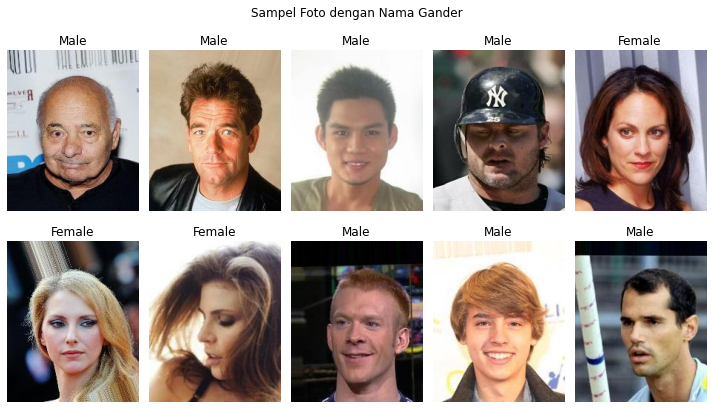

In [15]:
# Mendapatkan 10 baris pertama dari dataframe
df_subset = df_gender.head(10)

# Membuat suatu subplot dengan 2 baris dan 5 kolom
fig,axes = plt.subplots(nrows = 2, ncols = 5, figsize = (10, 6))

# Mengiterasi dataframe dan axis subplot
for index, (ax, row) in enumerate(zip(axes.flatten(), df_subset.iterrows())):
    # Mendapatkan nama file gambar dan nilai yang sesuai
    image_file = row[1]['image_id']
    value = row[1]['Gender']
    
    # Membaca foto dan menampilkan dalam bentuk figure
    image_path = os.path.join(IMG_PATH, image_file)
    image = plt.imread(image_path)
    ax.imshow(image)
    
    # Setting judul figure dari value pada dataframe
    title = str(value)
    ax.set_title(title)
    plt.suptitle('Sampel Foto dengan Nama Gander')
    
    # Menonaktifkan axis ticks dan labels
    ax.axis('off')
    
# Mengatur spasi antar subplots
plt.tight_layout()

# Menampilkan Figure
plt.show()

# Code Modif dari Chat GPT

## 1.6. Menghitung Jumlah Foto Male dan Female

In [16]:
# Menghitung Jumlah Foto Male vs Female
category_count = df_gender['Gender'].value_counts()
print(category_count)

# Code Modif dari Kaggle

Female    2953
Male      2047
Name: Gender, dtype: int64


In [17]:
# Foto dengan Category Terbanyak
higher_category = list(category_count.index)[0]
print('Foto Terbanyak pada Gender: ', higher_category)

# Code Modif dari Kaggle

Foto Terbanyak pada Gender:  Female


## 1.7. Balancing Jumlah Foto Male dan Female

In [18]:
# Mendapatkan indeks dari indeks foto higher_category
np.random.seed(42)
indices = df_gender[df_gender['Gender'] == higher_category].index
sample_size = category_count[0] - category_count[1]

# Membuang baris ekstra foto perempuan untuk memperbaiki masalah keseimbangan data 
drop_sample = np.random.choice(indices, sample_size, replace = False)
df_balance = df_gender.drop(drop_sample, axis = 'index')
df_balance

# Code Modif dari Kaggle

,image_id,Male,Gender
0,000051.jpg,1,Male
1,000052.jpg,1,Male
2,000065.jpg,1,Male
3,000166.jpg,1,Male
4,000198.jpg,-1,Female
...,...,...,...
4994,202276.jpg,1,Male
4995,202320.jpg,-1,Female
4996,202340.jpg,-1,Female
4997,202347.jpg,-1,Female


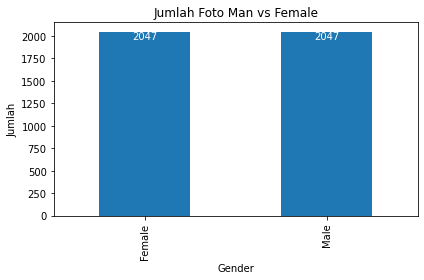

In [19]:
# Cek Kembali Jumlah Foto Man vs Female dan Visualisasikan

# Menghitung jumlah kategori "Male" vs "Female" dari kolom 'Gender'
balance_count = df_balance['Gender'].value_counts()

# Membuat bar plot dari hasil value_counts()
ax = balance_count.plot(kind='bar')

# Menampilkan nilai di atas setiap bar
for i, count in enumerate(balance_count):
    ax.text(i, count, str(count), ha='center', va='top', color = 'white')

# Memberi label sumbu x dan sumbu y
plt.title('Jumlah Foto Man vs Female')
ax.set_xlabel('Gender')
ax.set_ylabel('Jumlah')

# Menampilkan plot
plt.tight_layout()
plt.show()

# Code Modif dari Chat GPT

# 2. Data Splitting
## 2.1. Train, Test dan Validation Split

In [20]:
# Splitting Dataset
train_df, test_df = train_test_split(df_balance, test_size = 0.3)
test_df, validation_df = train_test_split(test_df, test_size=0.33)

Note :

* Data Train = 70%
* Data Test = 20%
* Data Validation = 10%

In [21]:
# Cek Jumlah Dataset per Masing-Masing Bagian
print('Total Train Sampel Images:', len(train_df))
print('Total Test Sampel Images:', len(test_df))
print('Total Validation Sampel Images:', len(validation_df))

Total Train Sampel Images: 2865
Total Test Sampel Images: 823
Total Validation Sampel Images: 406


## 2.2. Data Augmentasi untuk Train dan Validation Data

In [22]:
# Menentukan Ukuran Sampel dan Batch_Size
IMAGE_SIZE = (218, 178)
BATCH_SIZE = 32

In [23]:
# Membuat Data Augmentasi untuk Train Image

# Membuat objek ImageDataGenerator untuk augmentasi data pada data pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi intensitas piksel antara 0 dan 1
    rotation_range=15,  # Rentang rotasi gambar antara -40 derajat hingga +40 derajat
    width_shift_range=0.1,  # Rentang pergeseran horizontal gambar
    height_shift_range=0.1,  # Rentang pergeseran vertikal gambar
    shear_range=0.1,  # Rentang pergeseran sisi gambar
    zoom_range=0.2,  # Rentang perbesaran gambar
    horizontal_flip=True  # Membalik gambar secara horizontal
    #fill_mode='nearest'  # Metode pengisian piksel yang hilang
)

# Memuat gambar dan melakukan augmentasi pada data pelatihan
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    IMG_PATH + "/", 
    x_col = 'image_id',
    y_col = 'Gender',
    target_size = IMAGE_SIZE,
    class_mode = 'binary',
    batch_size = BATCH_SIZE
)

# Code Modif from Chat GPT & Kaggle

Found 2865 validated image filenames belonging to 2 classes.


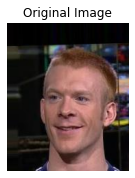

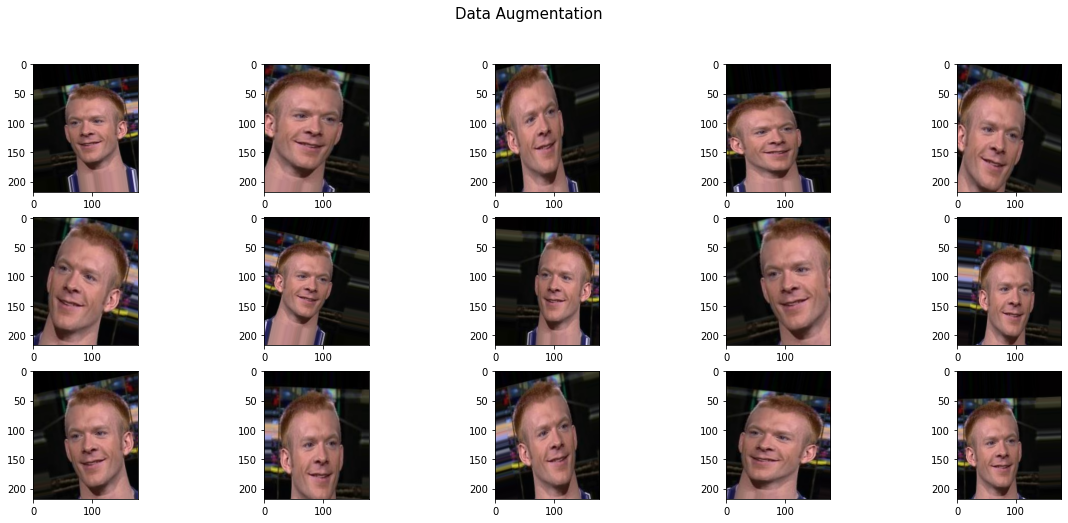

In [24]:
# Demonstrating Data Augmentation

# Membaca foto dari folder
image_path = os.path.join(IMG_PATH, '000282.jpg')  # Ganti 'nama_file.jpg' dengan nama file yang sesuai
original_image = plt.imread(image_path)

# Menampilkan foto asli
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Loading example image 
img = original_image
x = img_to_array(img)
x = x.reshape((1, ) + x.shape)

# Plotting Data Augmentation based on example image
plt.figure(figsize = (20, 8))
plt.suptitle('Data Augmentation', fontsize = 15)

i = 0
for batch in train_datagen.flow(x, batch_size = 1):
    plt.subplot(3, 5, i + 1)
    plt.grid = (False)
    plt.imshow(batch.reshape(218, 178, 3))
    
    if i == 14:
        break
    i += 1
    
plt.show()

# Code Modif dari Kaggle

In [25]:
# Normalisasi untuk Validation Image

# Membuat objek ImageDataGenerator untuk normalisasi data pada data validasi
validation_datagen = ImageDataGenerator(rescale = 1./255)

# Memuat gambar dan melakukan normalisasi pada data validasi
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df, 
    IMG_PATH + "/", 
    x_col = 'image_id',
    y_col = 'Gender',
    target_size = IMAGE_SIZE,
    class_mode = 'binary',
    batch_size = BATCH_SIZE
)

# Code Modif from Kaggle

Found 406 validated image filenames belonging to 2 classes.


In [26]:
# Normalisasi untuk Testing Image

# Membuat objek ImageDataGenerator untuk normalisasi data pada data testing
test_datagen = ImageDataGenerator(rescale = 1./255)

# Memuat gambar dan melakukan normalisasi pada data testing
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    IMG_PATH + "/",  
    x_col = 'image_id',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False
)

# Code Modif from Kaggle

Found 823 validated image filenames.


# 3. Data Modelling dengan Transfer Learning
## 3.1. Data Modelling and Training

### 3.1.1. Transfer Learning dengan VGG-19

In [27]:
# Transfer Learning dengan VGG-19
base_vgg_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape= IMAGE_SIZE + (3,)
)

In [29]:
# Melihat Arsitektur VGG-19
base_vgg_model.trainable = False # Freeze semua layer
base_vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 218, 178, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 218, 178, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 218, 178, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 109, 89, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 109, 89, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 109, 89, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 54, 44, 128)       0     

### 3.1.2. Membuat Arsitektur Fully Connected Layer

In [30]:
# Membuat Arsitektur Fully Connected
vgg_model = Sequential(
    [
    base_vgg_model,
    Flatten(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation="sigmoid")  
]
)
# Code Modif from Kaggle

In [31]:
# Menampilkan Arsitektur Deep Learning yang Akan Digunakan
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 6, 5, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 15360)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3932416   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1

### 3.1.3. Kompile Model dan Hyperparameter Tuning

In [32]:
# Kompile Model Deep Learning
base_learning_rate = 0.00001
vgg_model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate), 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [33]:
# Early Stopping dan Learning Rate Reduction

# Load Library
#from keras.callbacks import EarlyStopping, ReduceLROnPlateau
#
#earlystop = EarlyStopping(patience = 10)
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
#                                            patience=4, 
#                                            verbose=1, 
#                                            factor=0.5, 
#                                            min_lr=0.001)
#callbacks = [earlystop, learning_rate_reduction]

# Code Modif from Kaggle

In [34]:
# Model Architecture
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 6, 5, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 15360)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3932416   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1

### 3.1.4. Model Training

In [35]:
# Mengukur waktu pelatihan model
import time
start_time = time.time()

# Run Model Training
history = vgg_model.fit(train_generator, 
                        validation_data = validation_generator,
                        validation_steps = len(validation_df)//BATCH_SIZE,
                        steps_per_epoch = len(train_df)//BATCH_SIZE,
                        epochs = 10, 
                        verbose = 1, 
                        callbacks = False)

# Menghitung waktu pelatihan
training_time = time.time() - start_time
print("Total training time: {:.2f} seconds".format(training_time))
print("Total training time: {:.2f} hours".format(training_time/3600))

# Code Modif from Chat GPT & Kaggle

Epoch 1/10
89/89 [==============================] - 208s 2s/step - loss: 0.6822 - accuracy: 0.5605 - val_loss: 0.6314 - val_accuracy: 0.8307
Epoch 2/10
89/89 [==============================] - 215s 2s/step - loss: 0.6422 - accuracy: 0.6880 - val_loss: 0.5703 - val_accuracy: 0.8568
Epoch 3/10
89/89 [==============================] - 211s 2s/step - loss: 0.6006 - accuracy: 0.7487 - val_loss: 0.5128 - val_accuracy: 0.8698
Epoch 4/10
89/89 [==============================] - 214s 2s/step - loss: 0.5678 - accuracy: 0.7801 - val_loss: 0.4801 - val_accuracy: 0.8724
Epoch 5/10
89/89 [==============================] - 208s 2s/step - loss: 0.5416 - accuracy: 0.8052 - val_loss: 0.4655 - val_accuracy: 0.8750
Epoch 6/10
89/89 [==============================] - 211s 2s/step - loss: 0.5229 - accuracy: 0.8182 - val_loss: 0.4528 - val_accuracy: 0.8802
Epoch 7/10
89/89 [==============================] - 208s 2s/step - loss: 0.5090 - accuracy: 0.8334 - val_loss: 0.4397 - val_accuracy: 0.8854
Epoch 8/10
89

## 3.2. Validation Curves

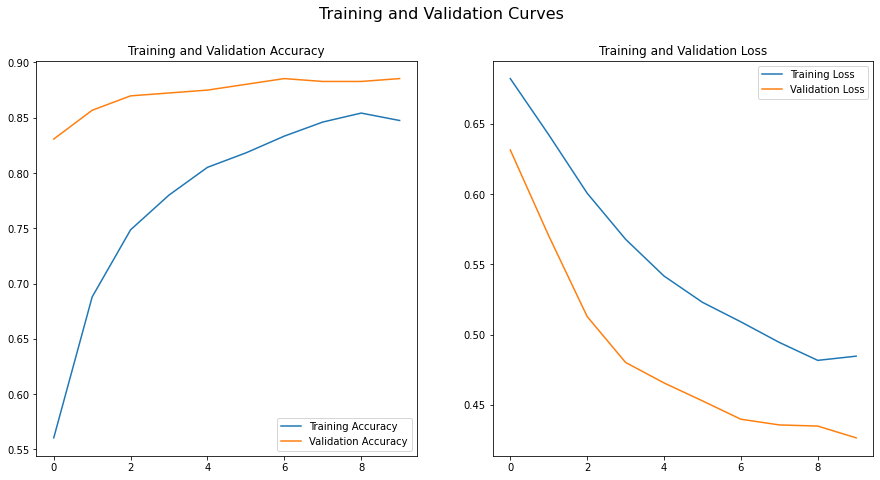

In [36]:
# Evaluasi Hasil Training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10) # Cek untuk di sesuaikan

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.suptitle('Training and Validation Curves', size = 16)
plt.subplots_adjust(top=0.93) # Mengatur jarak vertikal antara judul figure dan judul subplot
plt.savefig('Figure/Validation Curves Experiment 1.jpg', 
            dpi = 150, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Code Modif from previous workshop

In [37]:
# Evaluasi Model

print("Validation Akurasi")
print("Maksimum akurasi:  %.2f" % (np.max(val_acc)*100), "%")
print("Rata-rata akurasi:  %.2f" % (np.mean(val_acc)*100), "%")
print("Standar deviasi akurasi: %.2f" % np.std(val_acc))

print("")

print('Validation Loss')
print("Minimun loss:  %.2f" % (np.min(val_loss)*100), "%")
print("Rata-rata loss:  %.2f" % (np.mean(val_loss)*100), "%")
print("Standar deviasi loss: %.2f" % np.std(val_loss))

Validation Akurasi
Maksimum akurasi:  88.54 %
Rata-rata akurasi:  87.21 %
Standar deviasi akurasi: 0.02

Validation Loss
Minimun loss:  42.64 %
Rata-rata loss:  48.49 %
Standar deviasi loss: 0.06


# 4. Prediction and Testing the Model
## 4.1. Melakukan Prediksi pada Data Testing

In [38]:
# Mengevaluasi VGG Model pada Data test_generator
vgg_model.evaluate(test_generator)

26/26 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [39]:
# Melakukan Prediksi pada Dataset test_generator
BATCH_SIZE_TRAIN = 16
predict = vgg_model.predict(test_generator, steps = np.ceil(len(test_df)/BATCH_SIZE_TRAIN))

### 4.1.1. Membandingkan Label Aktual vs Prediksi pada Data Frame

In [40]:
# Membandingkan Antara Aktual vs Prediksi
prediction = predict.argmax(axis = -1)
test_df['Prediction'] = ['Male' if ele == 1 else 'Female' for ele in prediction]

# Cek Aktual vs Validation
test_df.head(10)

,image_id,Male,Gender,Prediction
1340,054920.jpg,-1,Female,Male
2088,083581.jpg,-1,Female,Female
3987,161265.jpg,-1,Female,Female
3815,153475.jpg,1,Male,Male
4164,168765.jpg,-1,Female,Female
472,019504.jpg,1,Male,Male
3735,150648.jpg,1,Male,Male
2531,101345.jpg,-1,Female,Female
648,026154.jpg,-1,Female,Male
4832,195769.jpg,1,Male,Male


### 4.1.2. Menampilkan Foto Beserta Label Gender dan Hasil Prediksi

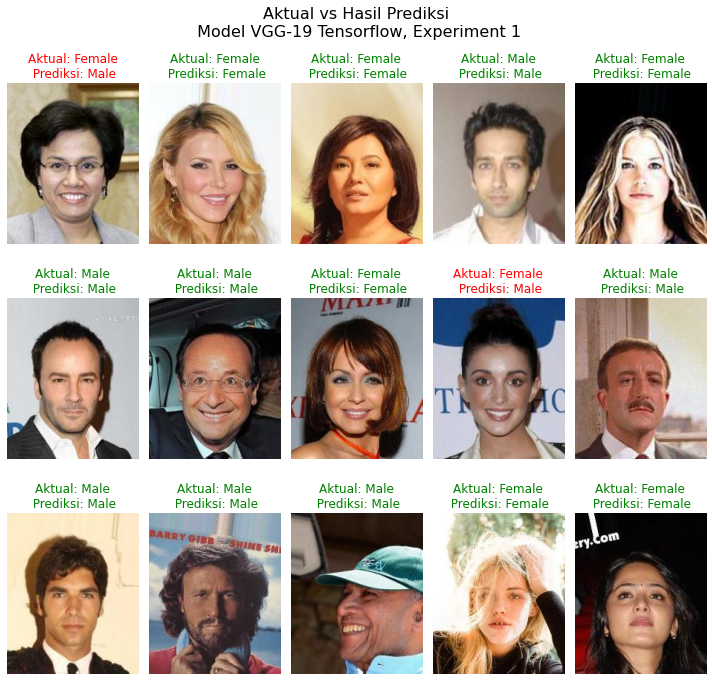

In [43]:
# Menampilkan Foto Beserta Label Gender dan Hasil Prediksi

# Get the first 10 rows from the data frame
df_test_subset = test_df.head(15)

# Create a subplot with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

# Iterate over the data frame subset and subplot axes
for index, (ax, row) in enumerate(zip(axes.flatten(), df_test_subset.iterrows())):
    # Get the image file name and corresponding value
    image_file = row[1]['image_id']
    value1 = row[1]['image_id']
    value2 = row[1]['Gender']
    value3 = row[1]['Prediction']
    
    # Read and plot the image
    image_path = os.path.join(IMG_PATH, image_file)
    image = plt.imread(image_path)
    ax.imshow(image)
    
    # Menambahkan judul dengan warna merah jika prediksi salah
    if value3 == value2:
        ax.set_title(f'Aktual: {value2}\n Prediksi: {value3}', color='green')
    else:
        ax.set_title(f'Aktual: {value2}\n Prediksi: {value3}', color='red')

    plt.suptitle("Aktual vs Hasil Prediksi\n Model VGG-19 Tensorflow, Experiment 1", size = 16)
    
    # Remove the axis ticks and labels
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

# Menyimpan Foto Hasil Prediksi
fig.savefig('Figure/Foto Aktual vs Prediksi Experiment 1.jpg', dpi=150)

# Code Modif dari Chat GPT

## 4.2. Confusion Matrix

In [44]:
# Mengkalkulasi Confusion Matrix
labels = ['Male', 'Female']

cm = confusion_matrix(test_df['Gender'], test_df['Prediction'], labels = labels)
cm

array([[395,  20],
       [ 69, 339]], dtype=int64)

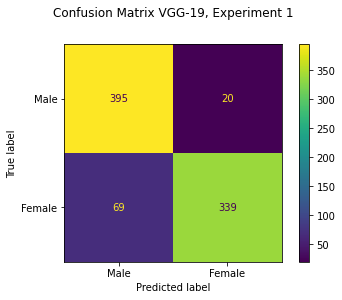

In [45]:
# Menampilkan Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                display_labels= labels,
                                )
disp.plot(include_values=True, ax=None, xticks_rotation='horizontal')
plt.title('Confusion Matrix VGG-19, Experiment 1', y=1.1)
plt.savefig('Figure/Confusion Experiment 1.jpg', 
            dpi = 150, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Code Modif from Chat GPT

## 4.3. Matrix Evaluasi

In [46]:
# Matriks Evaluasi

# Menghitung matriks confusion -> pada object 'cm_1' di atas

# Membuat laporan klasifikasi
target_names = ['Male', 'Female']  # Ganti dengan nama kelas yang sesuai
classification_rep = classification_report(test_df['Gender'], test_df['Prediction'],
                                            target_names=target_names, output_dict=True)

# Membuat DataFrame dari matriks confusion
df_confusion = pd.DataFrame(cm, columns=target_names, index=target_names)

# Membuat DataFrame dari laporan klasifikasi
df_classification = pd.DataFrame(classification_rep).transpose()

# Menampilkan tabel matriks evaluasi
print("Confusion Matrix:")
print(df_confusion)
print("\nClassification Report:")
print(df_classification)

# Code Modif from Chat GPT

Confusion Matrix:
        Male  Female
Male     395      20
Female    69     339

Classification Report:
              precision    recall  f1-score     support
Male           0.944290  0.830882  0.883963  408.000000
Female         0.851293  0.951807  0.898749  415.000000
accuracy       0.891859  0.891859  0.891859    0.891859
macro avg      0.897791  0.891345  0.891356  823.000000
weighted avg   0.897396  0.891859  0.891419  823.000000


In [47]:
# Matrix Evaluasi
print(classification_report(test_df['Gender'], test_df['Prediction'], target_names = ['Male', 'Female']))

# Code Modif from Chat GPT

              precision    recall  f1-score   support

        Male       0.94      0.83      0.88       408
      Female       0.85      0.95      0.90       415

    accuracy                           0.89       823
   macro avg       0.90      0.89      0.89       823
weighted avg       0.90      0.89      0.89       823



## 4.4. Menampilkan Foto Male yang Salah Prediksi

In [48]:
# Menyiapkan Data yang Salah Prediksi
wrong_df = test_df[test_df['Gender'] != test_df['Prediction']]

# menyiapkan Data yang Male di Prediksi sebagai Female
wrong_woman_df = wrong_df[wrong_df['Gender'] == 'Male']
wrong_woman_df.head()

,image_id,Male,Gender,Prediction
381,015784.jpg,1,Male,Female
2002,080610.jpg,1,Male,Female
1013,040454.jpg,1,Male,Female
2729,110815.jpg,1,Male,Female
2230,089241.jpg,1,Male,Female


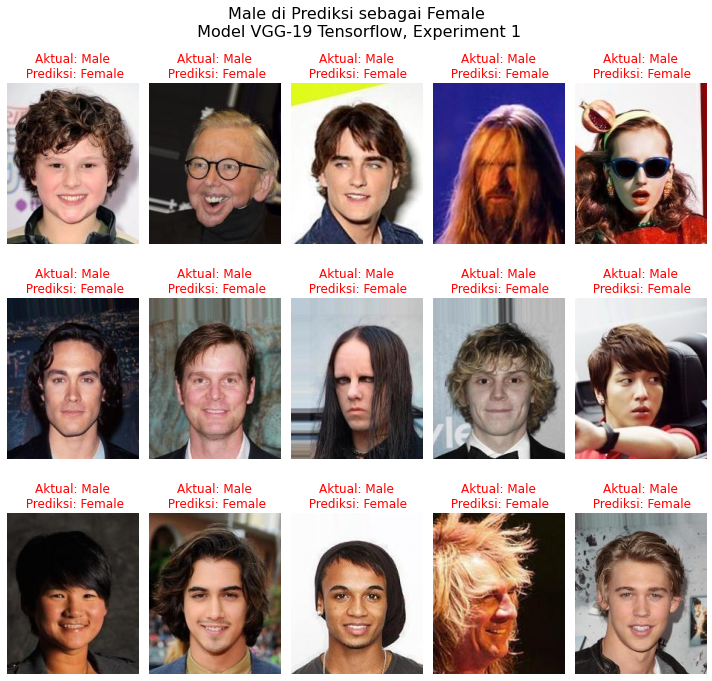

In [51]:
# Menampilkan Foto Male yang di Prediksi sebagai Female

# Create a subplot with 3 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

# Iterate over the data frame subset and subplot axes
for index, (ax, row) in enumerate(zip(axes.flatten(), wrong_woman_df.iterrows())):
    # Get the image file name and corresponding value
    image_file = row[1]['image_id']
    value1 = row[1]['image_id']
    value2 = row[1]['Gender']
    value3 = row[1]['Prediction']
    
    # Read and plot the image
    image_path = os.path.join(IMG_PATH, image_file)
    image = plt.imread(image_path)
    ax.imshow(image)
    
    # Menambahkan judul dengan warna merah jika prediksi salah
    if value3 == value2:
        ax.set_title(f'Aktual: {value2}\n Prediksi: {value3}', color='green')
    else:
        ax.set_title(f'Aktual: {value2}\n Prediksi: {value3}', color='red')

    plt.suptitle("Male di Prediksi sebagai Female\n Model VGG-19 Tensorflow, Experiment 1", size = 16)
    
    # Remove the axis ticks and labels
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

# Menyimpan Foto Hasil Prediksi
fig.savefig('Figure/Male di Prediksi sebagai Female Experiment 1.jpg', dpi=150)

# Code Modif dari Chat GPT

## 4.5. Menampilkan Foto Female yang Salah Prediksi

In [52]:
# Menyiapkan Data yang Salah Prediksi
wrong_df = test_df[test_df['Gender'] != test_df['Prediction']]

# menyiapkan Data yang Male di Prediksi sebagai Female
wrong_male_df = wrong_df[wrong_df['Gender'] == 'Female']
wrong_male_df.head()

,image_id,Male,Gender,Prediction
1340,054920.jpg,-1,Female,Male
648,026154.jpg,-1,Female,Male
2476,099012.jpg,-1,Female,Male
4618,186870.jpg,-1,Female,Male
4219,171056.jpg,-1,Female,Male


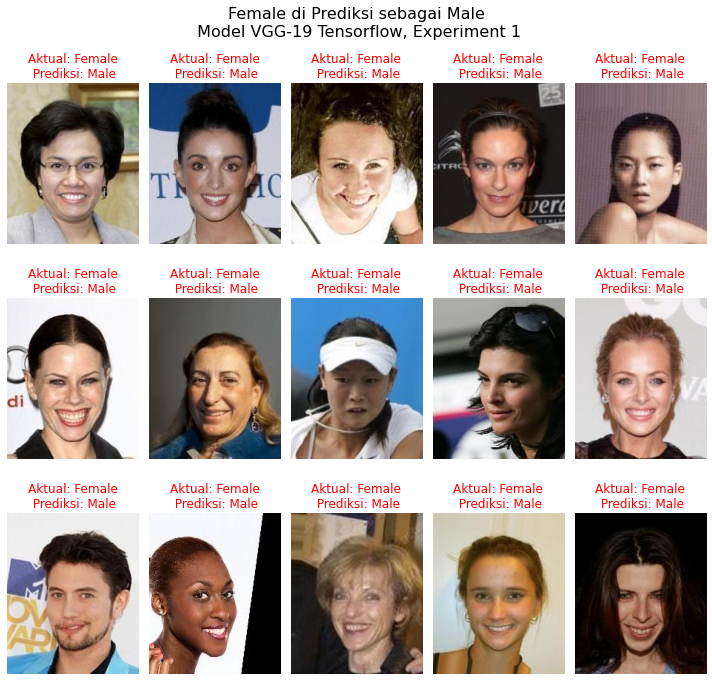

In [53]:
# Menampilkan Foto Female yang di Prediksi sebagai Male

# Create a subplot with 3 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

# Iterate over the data frame subset and subplot axes
for index, (ax, row) in enumerate(zip(axes.flatten(), wrong_male_df.iterrows())):
    # Get the image file name and corresponding value
    image_file = row[1]['image_id']
    value1 = row[1]['image_id']
    value2 = row[1]['Gender']
    value3 = row[1]['Prediction']
    
    # Read and plot the image
    image_path = os.path.join(IMG_PATH, image_file)
    image = plt.imread(image_path)
    ax.imshow(image)
    
    # Menambahkan judul dengan warna merah jika prediksi salah
    if value3 == value2:
        ax.set_title(f'Aktual: {value2}\n Prediksi: {value3}', color='green')
    else:
        ax.set_title(f'Aktual: {value2}\n Prediksi: {value3}', color='red')

    plt.suptitle("Female di Prediksi sebagai Male\n Model VGG-19 Tensorflow, Experiment 1", size = 16)
    
    # Remove the axis ticks and labels
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

# Menyimpan Foto Hasil Prediksi
fig.savefig('Figure/Female di Prediksi sebagai Male Experiment 1.jpg', dpi=150)

# Code Modif dari Chat GPT

# 5. Saving Model

In [54]:
# Menyimpan Model
vgg_model.save('./Model/Transfer VGG TF FTuning Experiment 1.h5')

# 6. References

[CelebFaces Attributes (CelebA) Dataset](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/code)

[90%+ accuracy, gender_classification using VGG-16](https://www.kaggle.com/code/ashar88/90-accuracy-gender-classification-using-vgg-16)

[Introduction to CNN Keras - 0.997 (top 6%)](https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)

[Starter: CelebFaces Attributes (CelebA) b5421ae1-e](https://www.kaggle.com/code/ky2019/starter-celebfaces-attributes-celeba-b5421ae1-e)

[Image Recognition - Gender Detection - Inception](https://www.kaggle.com/code/bmarcos/image-recognition-gender-detection-inceptionv3)

[Gender Classification (96% accuracy)](https://www.kaggle.com/code/dipeshmalhotra/gender-classification-96-accuracy)

[Gender Classification](https://www.kaggle.com/code/gerrygui/gender-classification/notebook)

Model Face Recognition ini Disiapkan oleh *Teguh Prasetyo* <br> <br> <img src="asset/teguh_dlj2.jpg" width=350 height=350 />

**My Contact :**

Email : teguh.prasetyo33@gmail.com

Linkedin : https://id.linkedin.com/in/teguh-prasetyo-b4196879

RPubs : https://rpubs.com/tprasetyo